<a href="https://colab.research.google.com/github/LordLean/dl_cw2_2022/blob/main/dl_cw2_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework 2: Generative Models

## Instructions

### Submission
Please submit one zip file on cate - *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question. **Please deliver the notebook including the outputs of the cells**
2. Your trained VAE model as *VAE_model.pth*
3. Your trained Generator and Discriminator: *DCGAN_model_D.pth and DCGAN_model_G.pth*


### Training
Training the GAN will take quite a long time (multiple hours), and so you have four options:
1. Use PaperSpace [as suggested for CW1](https://hackmd.io/@afspies/S1stL8Qnt)
2. Use Lab GPUs via SSH.  The VSCode Remote Develop extension is recommended for this. For general Imperial remote working instructions see [this post](https://www.doc.ic.ac.uk/~nuric/teaching/remote-working-for-imperial-computing-students.html). You'll also want to [setup your environment as outlined here](https://hackmd.io/@afspies/Bkd7Zq60K).
3. Use Colab and add checkpointing to the model training code; this is to handle the case where colab stops a free-GPU kernel after a certain number of hours (~4).
4. Use Colab Pro - If you do not wish to use PaperSpace then you can pay for Colab Pro. We cannot pay for this on your behalf (this is Google's fault).


### Testing
TAs will run a testing cell (at the end of this notebook), so you are required to copy your data ```transform``` and ```denorm``` functions to a cell near the bottom of the document (it is demarkated). You are advised to check that your implementations pass these tests (in particular, the jit saving and loading may not work for certain niche functions)

### General
You can feel free to add architectural alterations / custom functions outside of pre-defined code blocks, but if you manipulate the model's inputs in some way, please include the same code in the TA test cell, so our tests will run easily.

<font color="orange">**The deadline for submission is 19:00, Friday 25th February, 2022** </font>

## Setting up working environment
You will need to install pytorch and import some utilities by running the following cell:

In [1]:
!pip install -q torch torchvision altair seaborn
!git clone -q https://github.com/afspies/icl_dl_cw2_utils
from icl_dl_cw2_utils.utils.plotting import plot_tsne
from pathlib import Path
import tqdm

Here we have some default pathing options which vary depending on the environment you are using. You can of course change these as you please.

In [2]:
WORKING_ENV = 'COLAB' # Can be LABS,  or PAPERSPACE
USERNAME = 'arh121' # If working on Lab Machines - Your college username
assert WORKING_ENV in ['LABS', 'COLAB', 'PAPERSPACE']

if WORKING_ENV == 'COLAB':
    from google.colab import drive
    %load_ext google.colab.data_table
    content_path = '/content/drive/MyDrive/dl_cw_2'
    data_path = './data/'
    drive.mount('/content/drive/') # Outputs will be saved in your google drive

elif WORKING_ENV == 'LABS':
    content_path = '~/Documents/dl_cw_2' # You may want to change this
    # Your python env and training data should be on bitbucket
    data_path = f'/vol/bitbucket/{USERNAME}/dl_cw_data/'

else: # Using Paperspace
    # Paperspace does not properly render animated progress bars
    # Strongly recommend using the JupyterLab UI instead of theirs
    !pip install ipywidgets 
    content_path = '/notebooks'
    data_path = './data/'

content_path = Path(content_path)

Mounted at /content/drive/


## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

Each part is worth 50 points. 

The emphasis of both parts lies in understanding how the models behave and learn, however, some points will be available for getting good results with your GAN (though you should not spend too long on this).

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture with accompanying hyperparameters. More marks are awarded for using a Convolutional Encoder and Decoder.

b. Design an appropriate loss function and train the model.


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_VAE/'):
    os.makedirs(content_path/'CW_VAE/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


---
## Part 1.1a: Implement VAE (25 Points)
### Hyper-parameter selection


In [344]:
# Necessary Hyperparameters 
num_epochs = 10
learning_rate = 1e-3
batch_size = 32
latent_dim = 20 # Choose a value for the size of the latent space

# Additional Hyperparameters 
kernel_size = 4
filters = 8
image_channels = 1

weight_decay = 1e-7

# (Optionally) Modify transformations on input
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
])

# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    return x

### Data loading


In [345]:
train_dat = datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
test_dat = datasets.MNIST(data_path, train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change 
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, content_path/'CW_VAE/image_original.png')

### Model Definition

<figure>
  <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
  <figcaption>
    Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">1</a>.
  </figcaption>
</figure>


You will need to define:
* The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward



Hints:
- It is common practice to encode the log of the variance, rather than the variance
- You might try using BatchNorm

In [346]:
# *CODE FOR PART 1.1a IN THIS CELL*

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Encoder 
        self.enc_1 = nn.Conv2d(in_channels=image_channels, out_channels=filters, kernel_size=kernel_size, stride=2, padding=1) # out: c x 16 x 16
        self.enc_2 = nn.Conv2d(in_channels=filters, out_channels=filters*2, kernel_size=kernel_size, stride=2, padding=1) # out: c x 8 x 8
        self.enc_3 = nn.Conv2d(in_channels=filters*2, out_channels=filters*4, kernel_size=kernel_size, stride=2, padding=1) # out: c x 4 x 4
        self.enc_4 = nn.Conv2d(in_channels=filters*4, out_channels=64, kernel_size=kernel_size, stride=2, padding=0)

        self.fc_1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.fc_2 = nn.Linear(latent_dim, 64)

        self.dec_1 = nn.ConvTranspose2d(in_channels=64, out_channels=filters*8, kernel_size=kernel_size, stride=2, padding=0)
        self.dec_2 = nn.ConvTranspose2d(in_channels=filters*8, out_channels=filters*4, kernel_size=kernel_size, stride=2, padding=1)
        self.dec_3 = nn.ConvTranspose2d(in_channels=filters*4, out_channels=filters*2, kernel_size=kernel_size, stride=2, padding=1)
        self.dec_4 = nn.ConvTranspose2d(in_channels=filters*2, out_channels=image_channels, kernel_size=kernel_size, stride=2, padding=1)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = F.relu(self.enc_1(x))
        x = F.relu(self.enc_2(x))
        x = F.relu(self.enc_3(x))
        x = F.relu(self.enc_4(x))

        x = F.adaptive_avg_pool2d(x, 1).reshape(x.size(0), -1)

        h = self.fc_1(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        z = self.reparametrize(mu, logvar)

        return z, mu, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + (eps * std)
        return z
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        z = self.fc_2(z)

        z = z.view(-1,64,1,1)

        x = F.leaky_relu(self.dec_1(z))
        x = F.leaky_relu(self.dec_2(x))
        x = F.leaky_relu(self.dec_3(x))
        recon = torch.sigmoid(self.dec_4(x))
        return recon
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        z, mu, logvar = self.encode(x)
        recon = self.decode(z)
        return recon, mu, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

model = VAE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# loss criterion
criterion = nn.BCELoss(reduction='sum')
# criterion = nn.MSELoss(reduction='sum')

Total number of parameters is: 164945
VAE(
  (enc_1): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (fc_1): Linear(in_features=64, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=20, bias=True)
  (fc_2): Linear(in_features=20, out_features=64, bias=True)
  (dec_1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
  (dec_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


--- 

## Part 1.1b: Training the Model (5 Points)

### Defining a Loss
Recall the Beta VAE loss, with an encoder $q$ and decoder $p$:
$$ \mathcal{L}=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

In order to implement this loss you will need to think carefully about your model's outputs and the choice of prior.

There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training

#### Notes

https://www.microsoft.com/en-us/research/blog/less-pain-more-gain-a-simple-method-for-vae-training-with-less-of-that-kl-vanishing-agony/

In [282]:
def test_harness(model):
  '''
  wrapper function to evaluate model on test dataset.
  '''
  model.eval()

  running_loss = []
  running_recon = []
  running_kld = []
    
  with torch.no_grad():
    # Test.
    for batch_idx, (data, _) in enumerate(loader_test):

      data = data.to(device) 
      recon_data, mu, logvar = model(data)

      loss, bce, kld = loss_function_VAE(recon_data, data, mu, logvar, beta=beta)

      running_loss.append(loss.item())
      running_recon.append(bce.item())
      running_kld.append(kld.item())

  test_loss, recon_loss, kld_loss = [sum(x)/len(x) for x in [running_loss, running_recon, running_kld]]

  return test_loss, recon_loss, kld_loss

In [283]:
# *CODE FOR PART 1.1b IN THIS CELL*

def loss_function_VAE(recon_x, x, mu, logvar, beta=4):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        bce_loss = criterion(recon_x, x)
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return bce_loss + beta * kld, bce_loss, kld
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

losses = {
    "train":{
        "loss" : [],
        "recon_loss" : [],
        "kld_loss" : [],
    },
    "test":{
        "loss" : [],
        "recon_loss" : [],
        "kld_loss" : [],
    },
    "iter":{
        "loss" : [],
        "recon_loss" : [],
        "kld_loss" : [],
    }
}

model.train()
# <- You may wish to add logging info here
for epoch in range(num_epochs):  
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
        for batch_idx, (data, _) in enumerate(tepoch):   
            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################
            data = data.to(device) # Need at least one batch/random data with right shape -
            #             # This is required to initialize to model properly below
            #             # when we save the computational graph for testing (jit.save)
            recon_data, mu, logvar = model(data)

            # train loss per iteration.
            loss, bce, kld = loss_function_VAE(recon_data, data, mu, logvar, beta=beta)
            losses["iter"]["loss"].append(loss.item())
            losses["iter"]["recon_loss"].append(bce.item())
            losses["iter"]["kld_loss"].append(kld.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #######################################################################
            #                       ** END OF YOUR CODE **
            ####################################################################### 
            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=loss.item()/len(data))
    
    # Epoch:
    # train loss
    losses["train"]["loss"].append(loss.item())
    losses["train"]["recon_loss"].append(bce.item())
    losses["train"]["kld_loss"].append(kld.item())
    # test loss
    test_loss, test_recon_loss, test_kld_loss = test_harness(model)
    losses["test"]["loss"].append(test_loss)
    losses["test"]["recon_loss"].append(test_recon_loss)
    losses["test"]["kld_loss"].append(test_kld_loss)


    # save the model
    if epoch == num_epochs - 1:
        with torch.no_grad():
            torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                content_path/'CW_VAE/VAE_model.pth')


Epoch 4: 100%|██████████| 1875/1875 [00:35<00:00, 53.14batch/s, loss=202]


### Loss Explanation
Explain your choice of loss and how this relates to:

* The VAE Prior
* The output data domain
* Disentanglement in the latent space


In [199]:
# Any code for your explanation here

**YOUR ANSWER**

<h2>Part 1.2 (9 points)</h2>

a. Plot your loss curves

b. Show reconstructions and samples

c. Discuss your results from parts (a) and (b)

## Part 1.2a: Loss Curves (3 Points)
Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). If you experimented with different values of $\beta$, you may wish to display multiple plots (worth 1 point).

In [349]:
# beta testing

betas = [0.1, 0.5, 1, 4, 8]
betas.reverse()
beta_losses = {}

for beta in betas:
  print("\n\n")
  print("Beta: {}".format(beta))
  # Reinstance model
  model = VAE(latent_dim).to(device)
  params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print("Total number of parameters is: {}".format(params))
  print(model)
  # optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  # loss criterion
  criterion = nn.BCELoss(reduction='sum')

  losses = {
      "train":{
          "loss" : [],
          "recon_loss" : [],
          "kld_loss" : [],
      },
      "test":{
          "loss" : [],
          "recon_loss" : [],
          "kld_loss" : [],
      },
      "iter":{
          "loss" : [],
          "recon_loss" : [],
          "kld_loss" : [],
      }
  }

  model.train()
  # <- You may wish to add logging info here
  for epoch in range(num_epochs):  
      # <- You may wish to add logging info here
      with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
          for batch_idx, (data, _) in enumerate(tepoch):   
              #######################################################################
              #                       ** START OF YOUR CODE **
              #######################################################################
              data = data.to(device) # Need at least one batch/random data with right shape -
              #             # This is required to initialize to model properly below
              #             # when we save the computational graph for testing (jit.save)
              recon_data, mu, logvar = model(data)

              # train loss per iteration.
              loss, bce, kld = loss_function_VAE(recon_data, data, mu, logvar, beta=beta)
              losses["iter"]["loss"].append(loss.item())
              losses["iter"]["recon_loss"].append(bce.item())
              losses["iter"]["kld_loss"].append(kld.item())

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              #######################################################################
              #                       ** END OF YOUR CODE **
              ####################################################################### 
              if batch_idx % 20 == 0:
                  tepoch.set_description(f"Epoch {epoch}")
                  tepoch.set_postfix(loss=loss.item()/len(data))
      
      # Epoch:
      # train loss
      losses["train"]["loss"].append(loss.item())
      losses["train"]["recon_loss"].append(bce.item())
      losses["train"]["kld_loss"].append(kld.item())
      # test loss
      test_loss, test_recon_loss, test_kld_loss = test_harness(model)
      losses["test"]["loss"].append(test_loss)
      losses["test"]["recon_loss"].append(test_recon_loss)
      losses["test"]["kld_loss"].append(test_kld_loss)

  beta_losses[beta] = losses




Beta: 8
Total number of parameters is: 164945
VAE(
  (enc_1): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (fc_1): Linear(in_features=64, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=20, bias=True)
  (fc_2): Linear(in_features=20, out_features=64, bias=True)
  (dec_1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
  (dec_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


Epoch 9: 100%|██████████| 1875/1875 [00:36<00:00, 51.20batch/s, loss=239]





Beta: 4
Total number of parameters is: 164945
VAE(
  (enc_1): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (fc_1): Linear(in_features=64, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=20, bias=True)
  (fc_2): Linear(in_features=20, out_features=64, bias=True)
  (dec_1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
  (dec_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


Epoch 9: 100%|██████████| 1875/1875 [00:36<00:00, 51.98batch/s, loss=194]





Beta: 1
Total number of parameters is: 164945
VAE(
  (enc_1): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (fc_1): Linear(in_features=64, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=20, bias=True)
  (fc_2): Linear(in_features=20, out_features=64, bias=True)
  (dec_1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
  (dec_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


Epoch 9: 100%|██████████| 1875/1875 [00:37<00:00, 50.28batch/s, loss=160]





Beta: 0.5
Total number of parameters is: 164945
VAE(
  (enc_1): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (fc_1): Linear(in_features=64, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=20, bias=True)
  (fc_2): Linear(in_features=20, out_features=64, bias=True)
  (dec_1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
  (dec_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


Epoch 9: 100%|██████████| 1875/1875 [00:36<00:00, 50.74batch/s, loss=145]





Beta: 0.1
Total number of parameters is: 164945
VAE(
  (enc_1): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (fc_1): Linear(in_features=64, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=20, bias=True)
  (fc_2): Linear(in_features=20, out_features=64, bias=True)
  (dec_1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
  (dec_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


Epoch 9: 100%|██████████| 1875/1875 [00:34<00:00, 54.49batch/s, loss=108]


In [352]:
# *CODE FOR PART 1.2a IN THIS CELL*

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

def plot_performance(history_list, param_names, y_label, x_label="Epochs", ax=None):
  '''
  Plot training performance of model.
  '''
  # Loss list.
  for loss_curve, name in zip(history_list, param_names):
    sns.lineplot(x=range(len(loss_curve)), y=loss_curve, label=name)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

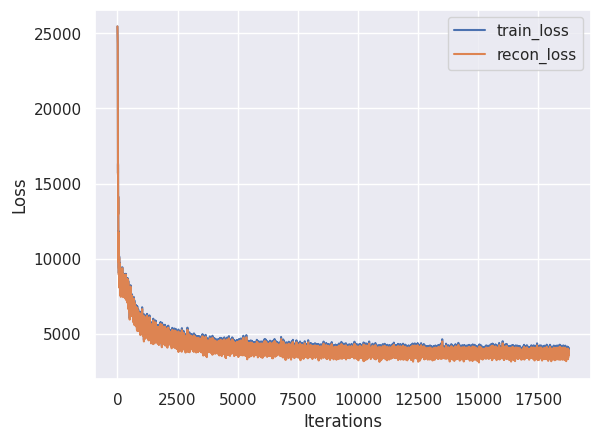

In [353]:
loss_list = [losses["iter"]["loss"], losses["iter"]["recon_loss"]]
names = ["train_loss", "recon_loss"]
plot_performance(loss_list, names, "Loss", "Iterations")

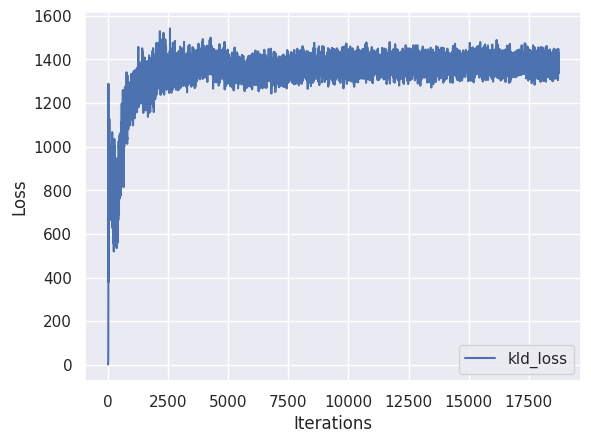

In [354]:
loss_list = [losses["iter"]["kld_loss"]]
names = ["kld_loss"]
plot_performance(loss_list, names, "Loss", "Iterations")

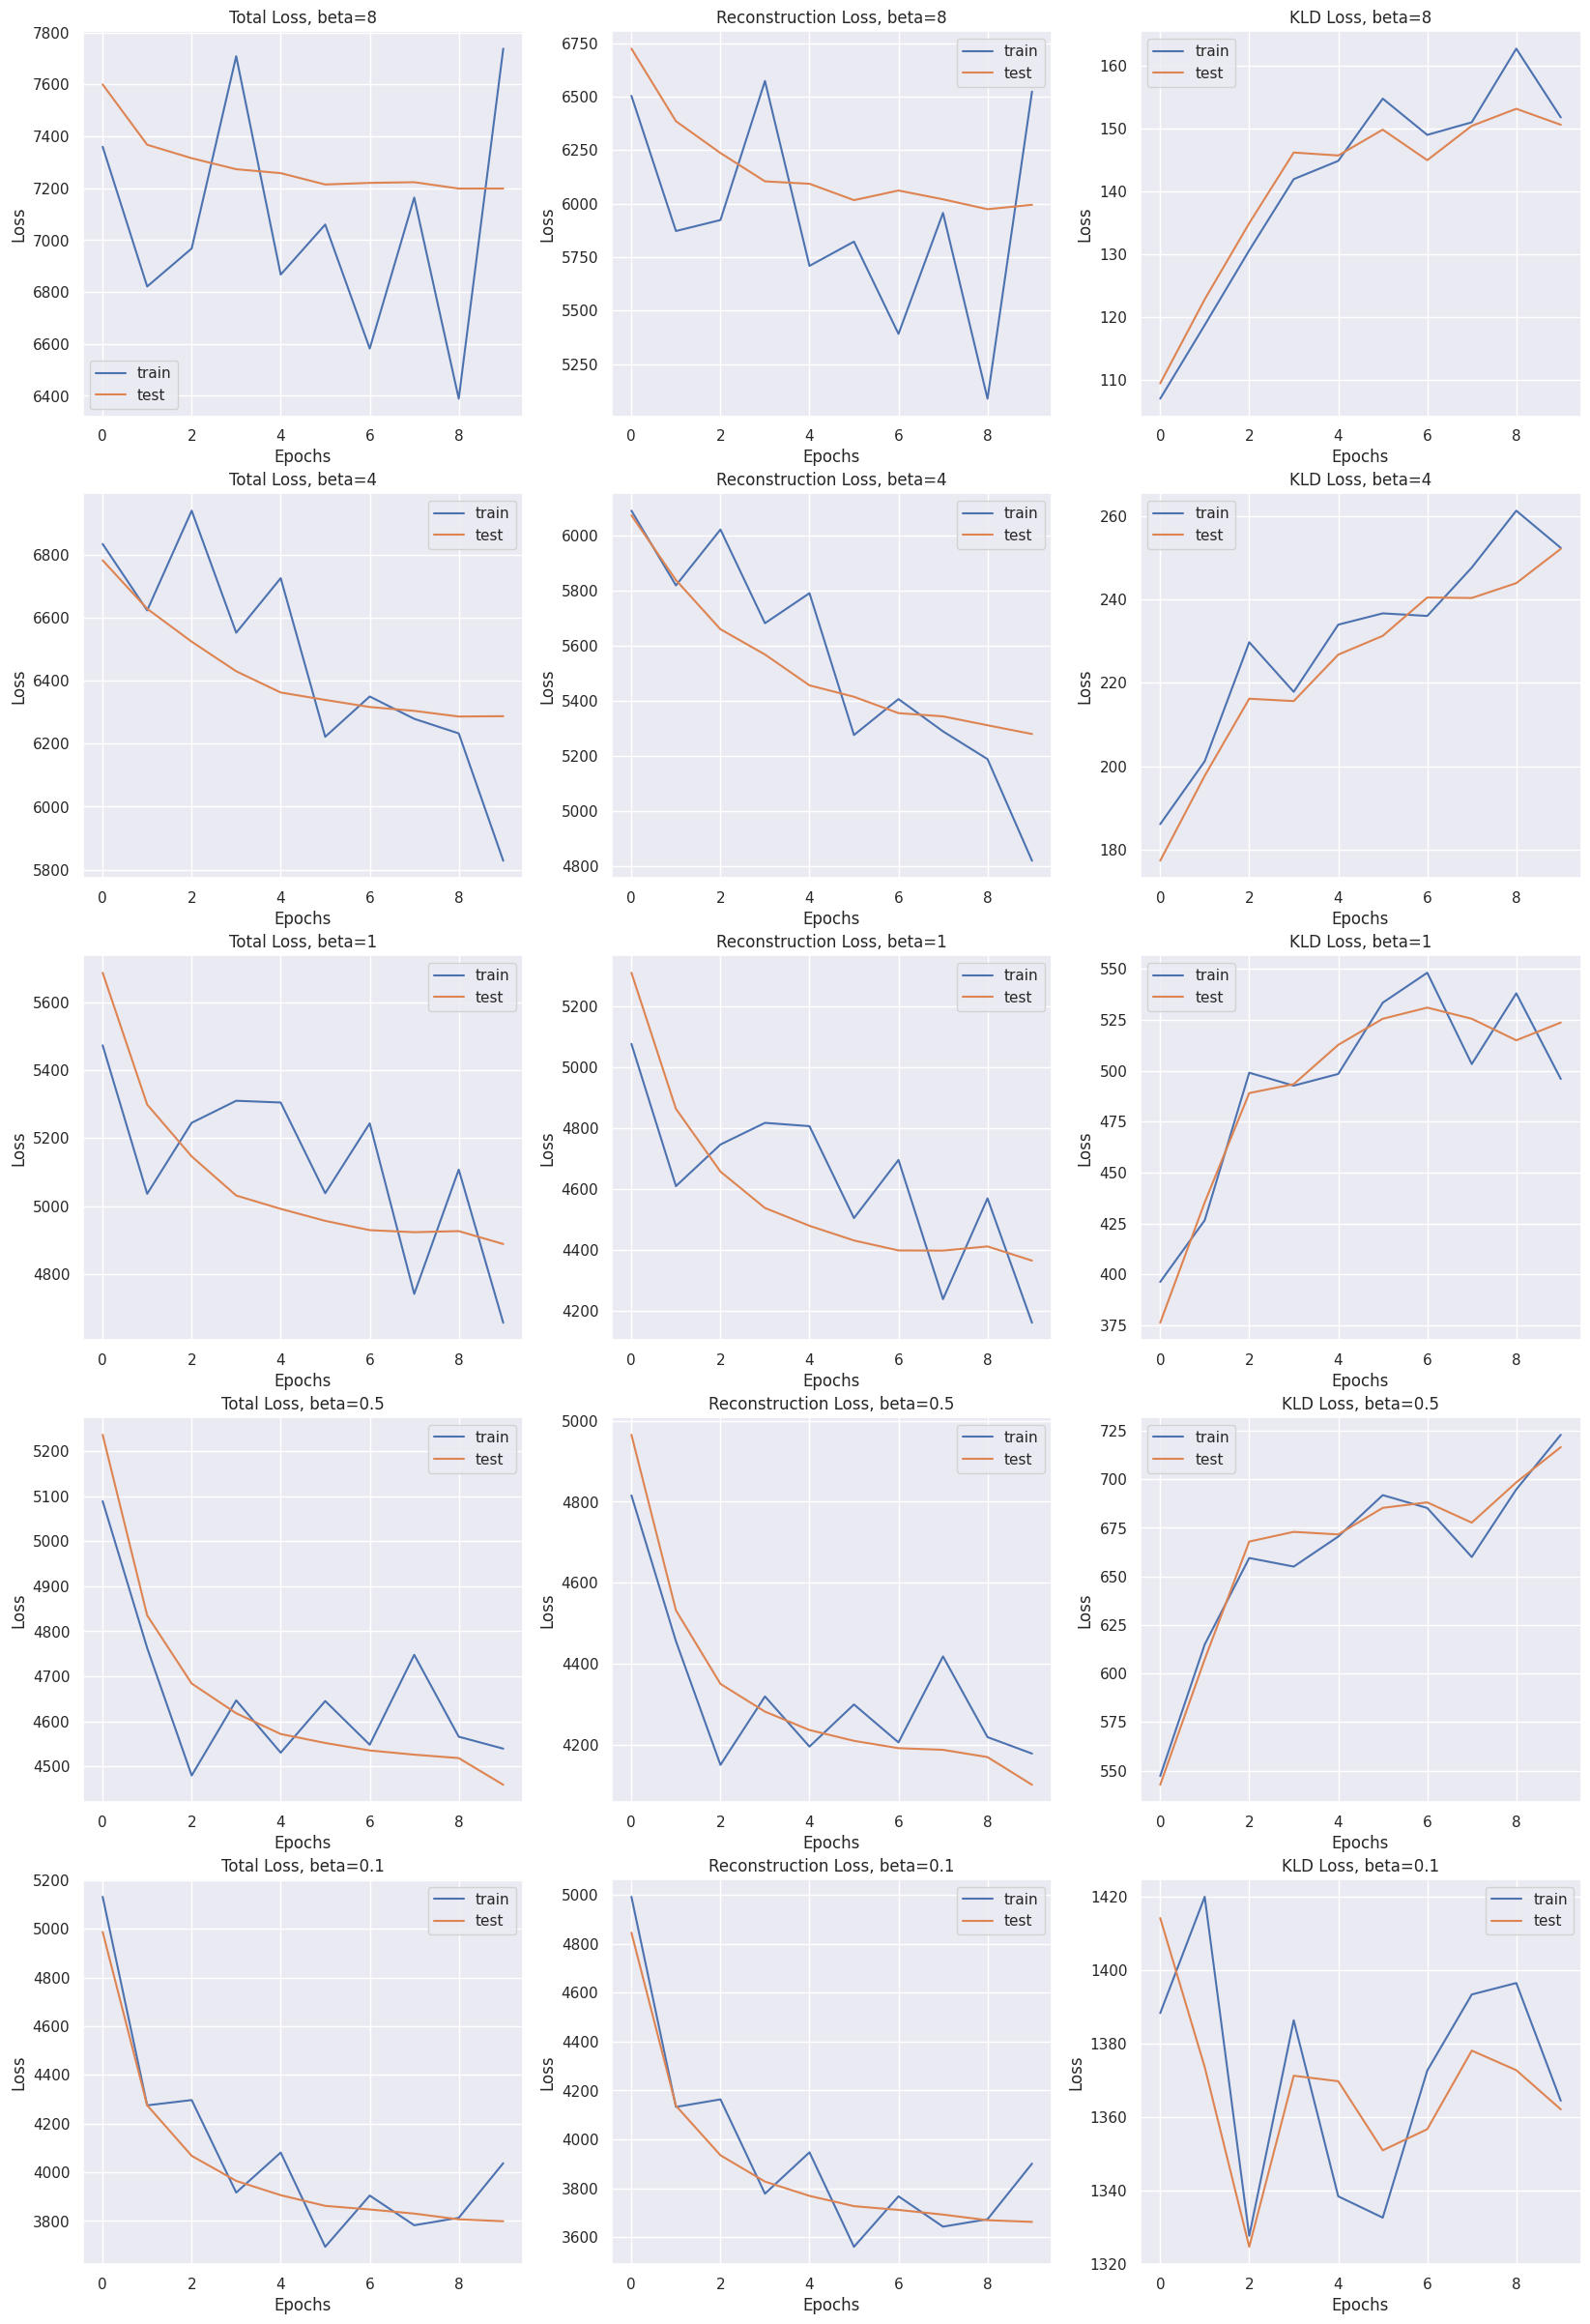

In [351]:
fig, ax = plt.subplots(5,3, figsize=(20,30))

for j, beta in enumerate(betas):
  for i, key in enumerate(["loss", "recon_loss", "kld_loss"]):
    sns.lineplot(x=range(num_epochs), y=beta_losses[beta]["train"][key], label="train", ax=ax[j,i])
    sns.lineplot(x=range(num_epochs), y=beta_losses[beta]["test"][key], label="test", ax=ax[j,i])

  ax[j,0].set_title("Total Loss, beta={}".format(beta))
  ax[j,0].set_xlabel("Epochs")
  ax[j,0].set_ylabel("Loss")
  ax[j,1].set_title("Reconstruction Loss, beta={}".format(beta))
  ax[j,1].set_xlabel("Epochs")
  ax[j,1].set_ylabel("Loss")
  ax[j,2].set_title("KLD Loss, beta={}".format(beta))
  ax[j,2].set_xlabel("Epochs")
  ax[j,2].set_ylabel("Loss")

fig.show()

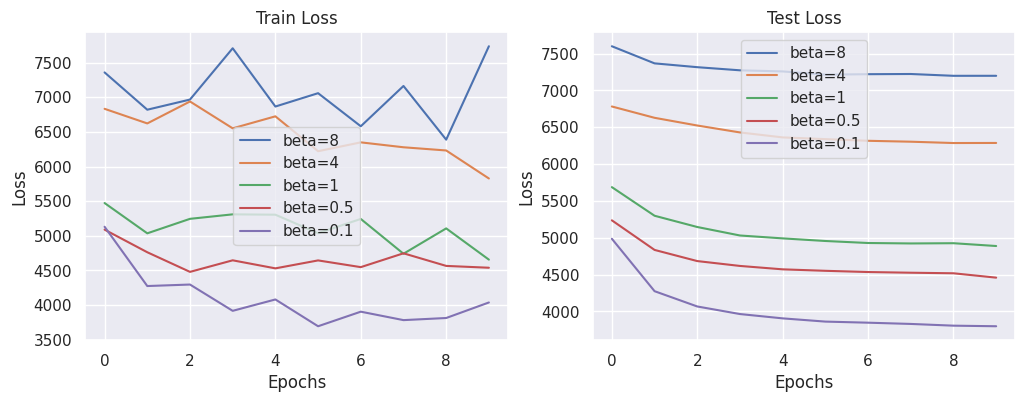

In [355]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

for beta in betas:
  sns.lineplot(x=range(num_epochs), y=beta_losses[beta]["train"]["loss"], label="beta={}".format(beta), ax=ax[0])
  sns.lineplot(x=range(num_epochs), y=beta_losses[beta]["test"]["loss"], label="beta={}".format(beta), ax=ax[1])

ax[0].set_title("Train Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_title("Test Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

fig.show()

In [356]:
import matplotlib
matplotlib.rc_file_defaults()

## Part 1.2b: Samples and Reconstructions (6 Points)
Visualize a subset of the images of the test set and their reconstructions **as well as** a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation).

For reference, here's [some samples from our VAE](https://imgur.com/NwNMuG3).


Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


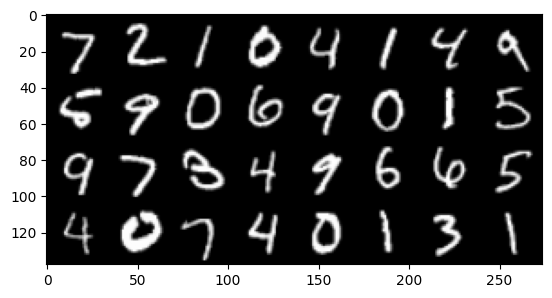

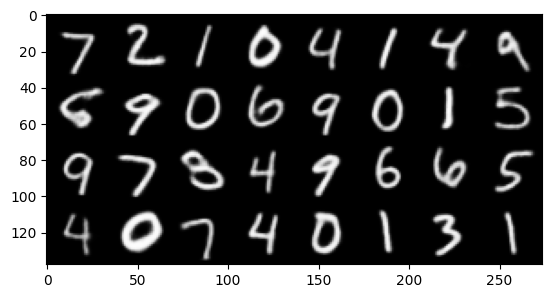

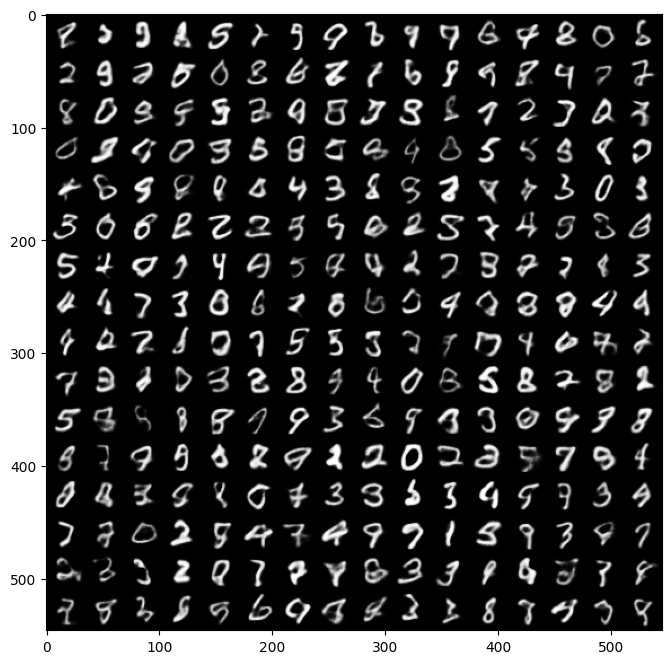

In [358]:
# *CODE FOR PART 1.2b IN THIS CELL*

# load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch, _, _ = model(fixed_input.to(device))
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

print('Generated Images')  
print('-'*50)
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



### Discussion
Provide a brief analysis of your loss curves and reconstructions: 
* What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)?
* Can you intuitively explain if this behaviour is desirable? 
* What is posterior collapse and did you observe it during training (i.e. when the KL is too small during the early stages of training)? 
    * If yes, how did you mitigate it? How did this phenomenon reflect on your output samples?
    * If no, why do you think that is?

**YOUR ANSWER**

---
<h2> Part 1.3 (11 points) <h2/>

Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Dimensionality Reduction of learned embeddings

b. Interpolating in the latent space

## Part 1.3a: T-SNE on Embeddings (7 Points)
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)  [(see implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). You can use a T-SNE implementation from a library such as scikit-learn. 

We've provided a function to visualize a subset of the data, but you are encouraged to also produce a matplotlib plot (please use different colours for each digit class).

In [ ]:
# *CODE FOR PART 1.3a IN THIS CELL

Performing TSNE


In [ ]:
# Interactive Visualization - Code Provided
test_dataloader = DataLoader(test_dat, 10000, shuffle=False)
""" Inputs to the function are
        z_embedded - Embedded X, Y positions for every point in test_dataloader
        test_dataloader - dataloader with batchsize set to 10000
        num_points - number of points plotted (will slow down with >1k)
"""
plot_tsne(z_embedded, test_dataloader, num_points=1000, darkmode=False)


In [ ]:
# Custom Visualizations

### Discussion
What do you observe? Discuss the structure of the visualized representations. 
* What do you observe? What role do the KL loss term and $\beta$ have, if any, in what you observe (multiple matplotlib plots may be desirable here)?
    * Consider Outliers
    * Counsider Boundaries
    * Consider Clusters
* Is T-SNE reliable? What happens if you change the parameters (don't worry about being particularly thorough). [This link](https://distill.pub/2016/misread-tsne/) may be helpful.

Note - If you created multiple plots and want to include them in your discussion, the best option is to upload them to (e.g.) google drive and then embed them via a **public** share link. If you reference local files, please include these in your submission zip, and use relative pathing if you are embedding them (with the notebook in the base directory)

**YOUR ANSWER**

## Part 1.3b: Interpolating in $z$ (4 Points)
Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?


In [ ]:
# CODE FOR PART 1.3b IN THIS CELL

### Discussion
What did you observe in the interpolation? Is this what you expected?
* Can you relate the interpolation to your T-SNE visualization

**YOUR ANSWER**

# Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures and tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to load and run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explanations of what you did in order to cope with mode collapse. 

## Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. 

b. Define a loss and implement the Training Loop

c. Visualize images sampled from your best model's generator ("Extension" Assessed on quality)

d. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).


_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get good marks. The attached model does not have to be perfect, and the extension marks for performance are only worth 10 points._

In [118]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

mean = torch.Tensor([0.4914, 0.4822, 0.4465])
std = torch.Tensor([0.247, 0.243, 0.261])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize = False):
    
    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_GAN'):
    os.makedirs(content_path/'CW_GAN')

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using cuda


### Part 2.1a: Implement DCGAN (8 Points)
Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small kernels, max pooling, RELU activations), in order to narrow down your possible choices.

<font color="red">**Your model should not have more than 25 Million Parameters**</font>

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

#### Data loading

In [119]:
batch_size =  64

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])
# note - data_path was initialized at the top of the notebook
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


We'll visualize a subset of the test set: 

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


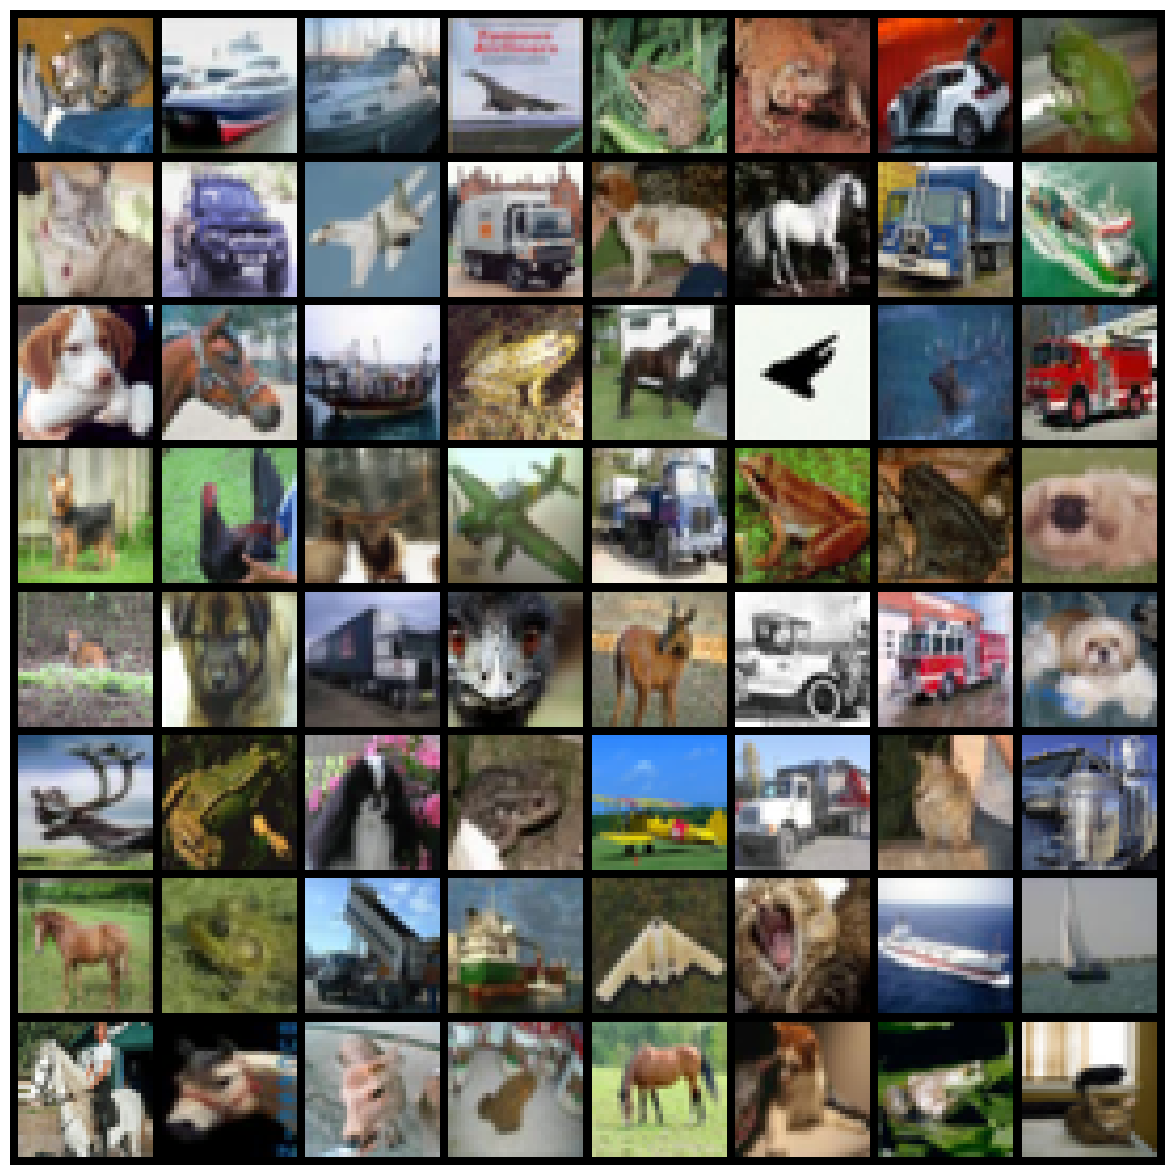

In [120]:
samples, _ = next(iter(loader_test))

samples = samples.cpu()
samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)

#### Model Definition
Define hyperparameters and the model

In [97]:
# *CODE FOR PART 2.1 IN THIS CELL*

# Choose the number of epochs, the learning rate
# and the size of the Generator's input noise vetor.

num_epochs = 20
learning_rate = 0.0002
latent_vector_size = 80

# Other hyperparams
image_channels = 3

gen_feature_maps = 64
dis_feature_maps = 64

In [98]:
# *CODE FOR PART 2.1 IN THIS CELL*


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.seq = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_vector_size, gen_feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_feature_maps * 8),
            nn.ReLU(True),
            # state size. (gen_feature_maps*8) x 4 x 4
            nn.ConvTranspose2d(gen_feature_maps * 8, gen_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feature_maps * 4),
            nn.ReLU(True),
            # state size. (gen_feature_maps*4) x 8 x 8
            nn.ConvTranspose2d( gen_feature_maps * 4, gen_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feature_maps * 2),
            nn.ReLU(True),
            # state size. (gen_feature_maps*2) x 16 x 16
            nn.ConvTranspose2d( gen_feature_maps * 2, gen_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feature_maps),
            nn.ReLU(True),
            # state size. (gen_feature_maps) x 32 x 32
            nn.ConvTranspose2d( gen_feature_maps, image_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (gen_feature_maps) x 64 x 64
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    # You can modify the arguments of this function if needed
    def forward(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.seq(z)       
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.seq = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(image_channels, dis_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (dis_feature_maps) x 32 x 32
            nn.Conv2d(dis_feature_maps, dis_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (dis_feature_maps*2) x 16 x 16
            nn.Conv2d(dis_feature_maps * 2, dis_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (dis_feature_maps*4) x 8 x 8
            nn.Conv2d(dis_feature_maps * 4, dis_feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (dis_feature_maps*8) x 4 x 4
            nn.Conv2d(dis_feature_maps * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    # You can modify the arguments of this function if needed
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.seq(x)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        return out


In [100]:
##### take 2

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # self.alpha = nn.Parameter(torch.tensor(0.5, requires_grad=True)) # learnable tanh scaler

        self.seq = nn.Sequential(
            nn.ConvTranspose2d( latent_vector_size, gen_feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_feature_maps * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(gen_feature_maps * 8, gen_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feature_maps * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( gen_feature_maps * 4, gen_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feature_maps * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( gen_feature_maps * 2, image_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.seq(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(image_channels, dis_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feature_maps, dis_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feature_maps * 2, dis_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feature_maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.seq(input)

<h2> Initialize Model and print number of parameters </h2>

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [101]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [102]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3284736
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(80, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


Total number of parameters in Discriminator is: 663296
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

### Part 2.1b: Training the Model (12 Points)

#### Defining a Loss

In [103]:
criterion = nn.BCELoss()

In [104]:
# # You can modify the arguments of this function if needed
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

<h3>Choose and initialize optimizers</h3>

In [105]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

<h3> Define fixed input vectors to monitor training and mode collapse. </h3>

In [106]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
# Additional input variables should be defined here
# label smoothing
real_label = 0.9
fake_label = 0.1

#### Training Loop

Complete the training loop below. We've defined some variables to keep track of things during training:
* errD: Loss of Discriminator after being trained on real and fake instances
* errG: Loss of Generator
* D_x: Output of Discriminator for real images
* D_G_z1: Output of Discriminator for fake images (When Generator is not being trained)
* D_G_z2: Output of Discriminator for fake images (When Generator is being trained)

In [107]:
train_losses_G = []
train_losses_D = []

# <- You may wish to add logging info here
for epoch in range(num_epochs):
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
        for i, data in enumerate(tepoch):
            train_loss_D = 0
            train_loss_G = 0
            
            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            model_D.zero_grad()
            real_batch = data[0].to(device)
            label = torch.full((real_batch.size(0),), real_label, dtype=torch.float, device=device)
            # train with real
            output = model_D(real_batch).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(real_batch.size(0), latent_vector_size, 1, 1, device=device)
            fake = model_G(noise)
            label.fill_(fake_label)

            output = model_D(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake

            train_loss_D = errD ##
            
            optimizerD.step()

            # (2) Update G network: maximize log(D(G(z)))
            model_G.zero_grad()
            label.fill_(real_label)
            output = model_D(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()

            train_loss_G = errG ##

            optimizerG.step()

            ####################################################################### 
            #                       ** END OF YOUR CODE **
            ####################################################################### 
            # Logging 
            if i % 50 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                  Loss_D=errD.item(), Loss_G=errG.item())

    if epoch == 0:
        save_image(denorm(real_batch.cpu()).float(), content_path/'CW_GAN/real_samples.png')
    with torch.no_grad():
        fake = model_G(fixed_noise)
        save_image(denorm(fake.cpu()).float(), str(content_path/'CW_GAN/fake_samples_epoch_%03d.png') % epoch)
    train_losses_D.append(train_loss_D.item() / len(loader_train))
    train_losses_G.append(train_loss_G.item() / len(loader_train))
    
# save  models 
# if your discriminator/generator are conditional you'll want to change the inputs here
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), content_path/'CW_GAN/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake)), content_path/'CW_GAN/GAN_D_model.pth')

Epoch 19: 100%|██████████| 782/782 [00:29<00:00, 26.69batch/s, D_G_z=0.102/0.090, D_x=0.872, Loss_D=0.67, Loss_G=2.22]


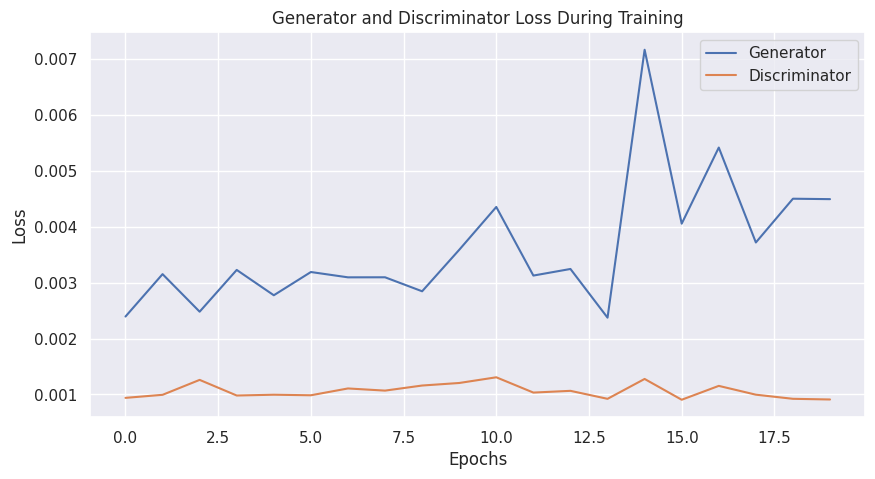

In [110]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_theme(style="darkgrid")

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
sns.lineplot(x=range(len(train_losses_G)), y=train_losses_G, label="Generator")
sns.lineplot(x=range(len(train_losses_D)), y=train_losses_D, label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


matplotlib.rc_file_defaults()

## Part 2.1c: Results (10 Points)
This part is fairly open-ended, but not worth too much so do not go crazy. The table below shows examples of what are considered good samples. Level 3 and above will get you 10/10 points, level 2 will roughly get you 5/10 points and level 1 and below will get you 0/10 points.

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="https://drive.google.com/uc?id=1wQ2f10-A1Vs7k0LMfBPPyYTsPlkBF9QE" width="%30">
    <br>
    <em style="color: grey">Level 1</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1wlDhX4hROET4s8Ndxn8nhj_0RLM2rnuG" width="%30">
    <br>
    <em style="color: grey">Level 2</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1w9VrgfJLCRaTPhwoFVYdYhtCeaQmFHGb" width="%30">
    <br>
    <em style="color: grey">Level 3</em>
  </p> 
</td>
</tr></table>

### Generator samples

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


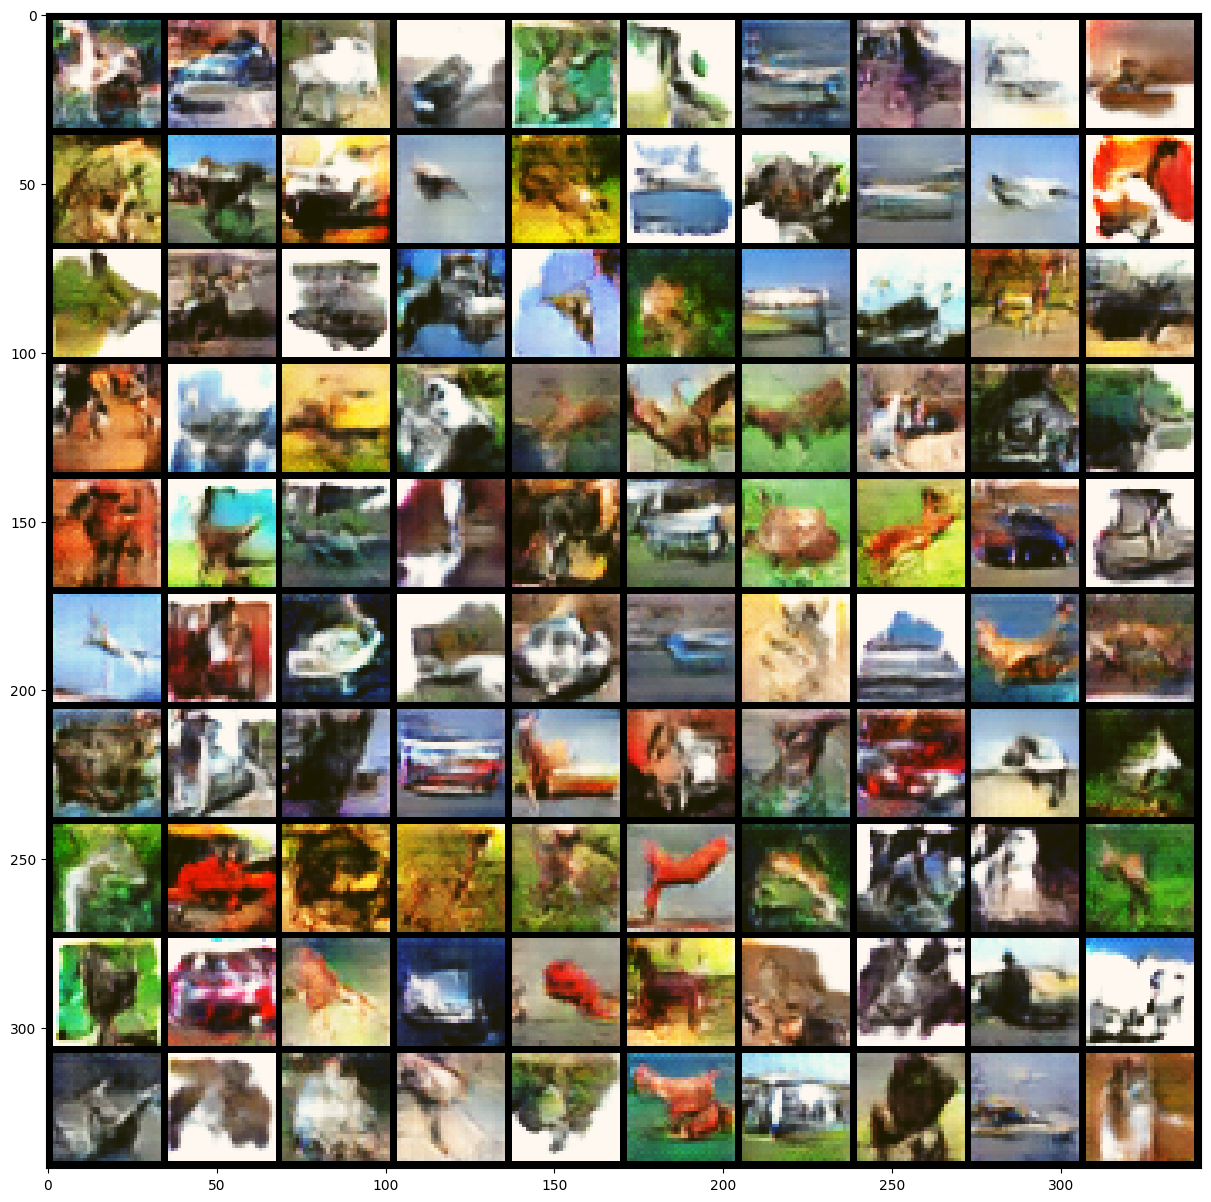

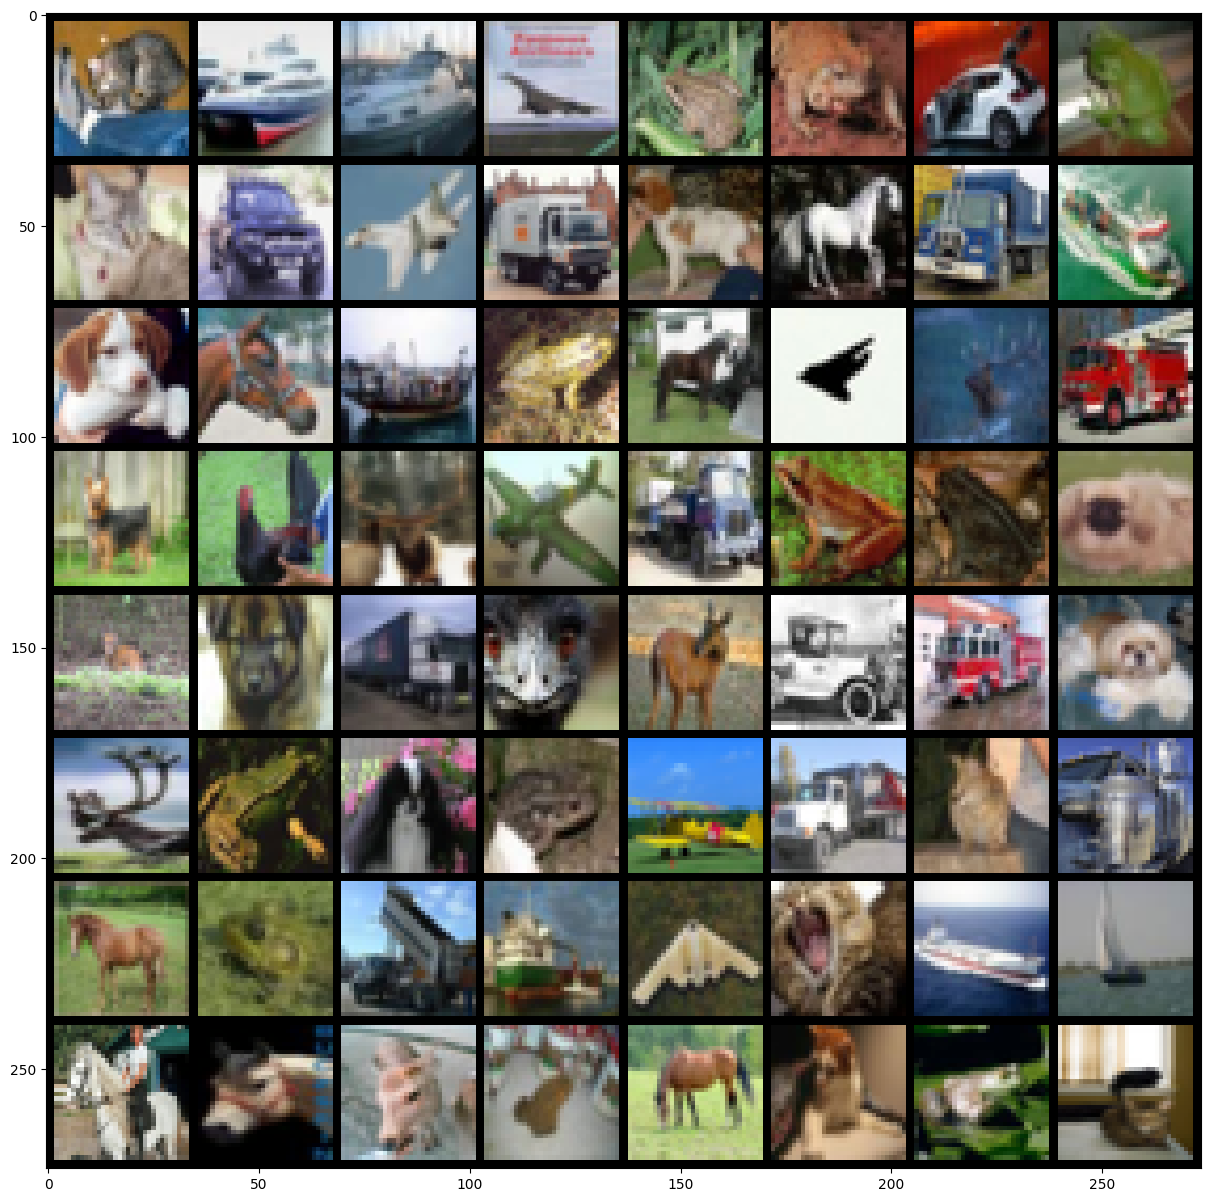

In [123]:
input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=True, 
                        range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    save_image(generated, content_path/'CW_GAN/Teaching_final.png')
    show(generated) # note these are now class conditional images columns rep classes 1-10

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)

## Part 2.1d: Engineering Choices (10 Points)

Discuss the process you took to arrive at your final architecture. This should include:

* Which empirically useful methods did you utilize
* What didn't work, what worked and what mattered most
* Are there any tricks you came across in the literature etc. which you suspect would be helpful here

**Your Answer**

## Part 2.2: Understanding GAN Training (5 points)


### Loss Curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

Make sure that the version of the notebook you deliver includes these results.

In [ ]:
# ANSWER FOR PART 2.2 IN THIS CELL*

### Discussion

Do your loss curves look sensible? What would you expect to see and why?

**YOUR ANSWER**

## Part 2.3: Understanding Mode Collapse (5 points) 
**Your task:**
 
Describe the what causes the phenomenon of Mode Collapse and how it may manifest in the samples from a GAN. 

Based on the images created by your generator using the `fixed_noise` vector during training, did you notice any mode collapse? what this behaviour may be attributed to, and what did you try to eliminate / reduce it?

In [ ]:
# Any additional code

### Discussion


**YOUR ANSWER**



# TA Test Cell
TAs will run this cell to ensure that your results are reproducible, and that your models have been defined suitably. 

<font color="orange"> <b> Please provide the input and output transformations required to make your VAE and GANs work. If your GAN generator requires more than just noise as input, also specify this below (there are two marked cells for you to inspect) </b></font>


In [ ]:
# If you want to run these tests yourself, change directory:
# %cd '.../dl_cw2/'
ta_data_path = "../data" # You can change this to = data_path when testing

In [ ]:
!pip install -q torch torchvision

In [ ]:
# Do not remove anything here
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt 

show = lambda img: plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

# Do not change this cell!
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [ ]:
############# CHANGE THESE (COPY AND PASTE FROM YOUR OWN CODE) #############
vae_transform = transforms.Compose([
    transforms.ToTensor(),
])

def vae_denorm(x):
    return x

def gan_denorm(x):
    return x

gan_latent_size = 

# If your generator requires something other than noise as input, please specify
# two cells down from here

In [ ]:
# Load VAE Dataset
test_dat = datasets.MNIST(ta_data_path, train=False, transform=vae_transform, 
                          download=True)
vae_loader_test = DataLoader(test_dat, batch_size=32, shuffle=False)

In [ ]:
############# MODIFY IF NEEDED #############
vae_input, _ = next(iter(vae_loader_test))

# If your generator is conditional, then please modify this input suitably
input_noise = torch.randn(100, gan_latent_size, 1, 1, device=device)
gan_input = [input_noise] # In case you want to provide a tuple, we wrap ours

In [ ]:
# VAE Tests
# TAs will change these paths as you will have provided the model files manually
"""To TAs, you should have been creating a folder with the student uid
   And the .ipynb + models in the root. Then that path is './VAE_model.pth' etc.
"""
vae = model_G = torch.jit.load('./CW_VAE/VAE_model.pth')
vae.eval()

# Check if VAE is convolutional
def recurse_cnn_check(parent, flag):
    if flag:
        return flag
    children = list(parent.children())
    if len(children) > 0:
        for child in children:
            flag = flag or recurse_cnn_check(child, flag)
    else:
        params = parent._parameters
        if 'weight' in params.keys():
            flag = params['weight'].ndim == 4
    return flag

has_cnn = recurse_cnn_check(vae, False)
print("Used CNN" if has_cnn else "Didn't Use CNN")

vae_in = make_grid(vae_denorm(vae_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_in)

vae_test = vae(vae_input.to(device))[0].detach()
vae_reco = make_grid(vae_denorm(vae_test), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_reco)

In [ ]:
# GAN Tests
model_G = torch.jit.load('./CW_GAN/GAN_G_model.pth')
model_D = torch.jit.load('./CW_GAN/GAN_D_model.pth')
[model.eval() for model in (model_G, model_D)]  

# Check that GAN doesn't have too many parameters
num_param = sum(p.numel() for p in [*model_G.parameters(),*model_D.parameters()])

print(f"Number of Parameters is {num_param} which is", "ok" if num_param<25E+6 else "not ok")

# visualize the generated images
generated = model_G(*gan_input).cpu()
generated = make_grid(gan_denorm(generated)[:100].detach(), nrow=10, padding=2, normalize=False, 
                    range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
plt.axis('off')
show(generated)